<a href="https://colab.research.google.com/github/chrisvidetto1/Portfolio/blob/master/COVID19_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### COVID-19 HealthData.gov - Exploratory Data Analysis
### Submitted by: Christopher Videtto
#### Stony Brook University
#### Faculty: Prof. Hants Williams Ph.D

In [ ]:
### Create the environment
!sudo apt-get install python3-dev default-libmysqlclient-dev
!pip install pymysql

In [2]:
### Import the libraries
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
import seaborn as sns
import sqlalchemy as sqlalchemy
from sqlalchemy import create_engine


## Exploring the Data

Query HealthData.gov for the .csv file of COVID19 cases and deaths by state over time

In [ ]:
covid19 = pd.read_csv("https://data.cdc.gov/resource/9mfq-cb36.csv")
covid19

,submission_date,state,tot_cases,conf_cases,prob_cases,new_case,pnew_case,tot_death,conf_death,prob_death,new_death,pnew_death,created_at,consent_cases,consent_deaths
0,2020-01-22T00:00:00.000,CO,0,NaN,NaN,0.0,NaN,0,NaN,NaN,0.0,NaN,2020-03-26T16:22:39.452,Agree,Agree
1,2020-01-23T00:00:00.000,CO,0,NaN,NaN,0.0,NaN,0,NaN,NaN,0.0,NaN,2020-03-26T16:22:39.452,Agree,Agree
2,2020-01-24T00:00:00.000,CO,0,NaN,NaN,0.0,NaN,0,NaN,NaN,0.0,NaN,2020-03-26T16:22:39.452,Agree,Agree
3,2020-01-25T00:00:00.000,CO,0,NaN,NaN,0.0,NaN,0,NaN,NaN,0.0,NaN,2020-03-26T16:22:39.452,Agree,Agree
4,2020-01-26T00:00:00.000,CO,0,NaN,NaN,0.0,NaN,0,NaN,NaN,0.0,NaN,2020-03-26T16:22:39.452,Agree,Agree
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,2020-09-26T00:00:00.000,SC,145273,141338.0,3935.0,1371.0,89.0,3323,3141.0,182.0,26.0,-1.0,2020-09-27T13:39:49.124,Agree,Agree
996,2020-01-22T00:00:00.000,CT,0,NaN,NaN,0.0,NaN,0,NaN,NaN,0.0,NaN,2020-03-26T16:22:39.452,Agree,Agree
997,2020-01-23T00:00:00.000,CT,0,NaN,NaN,0.0,NaN,0,NaN,NaN,0.0,NaN,2020-03-26T16:22:39.452,Agree,Agree
998,2020-01-24T00:00:00.000,CT,0,NaN,NaN,0.0,NaN,0,NaN,NaN,0.0,NaN,2020-03-26T16:22:39.452,Agree,Agree


#### Something is wrong with their API because we should be pulling in 15k 
#### records but we see there is only 1,000 here.
#### Instead, let download the data as a .csv and then upload the data into a database so there will be no issues

In [ ]:
MYSQL_HOSTNAME = 'ahi.c96anxcynoyv.us-east-1.rds.amazonaws.com' 
MYSQL_USER = 'admin'
MYSQL_PASSWORD = '46****56'
MYSQL_DATABASE = 'chris_v'

connection_string = f'mysql+pymysql://{MYSQL_USER}:{MYSQL_PASSWORD}@{MYSQL_HOSTNAME}/{MYSQL_DATABASE}'
engine = create_engine(connection_string)

In [ ]:
### Lets see what databases are in there right now

engine = create_engine(connection_string)
insp = sqlalchemy.inspect(engine)
db_list = insp.get_schema_names()
db_list

['ahi_medications',
 'cdc',
 'chris_v',
 'dbnames',
 'hantslikesdatabases',
 'hhs_covid',
 'hospital',
 'hospital2',
 'information_schema',
 'medication',
 'medications',
 'mysql',
 'performance_schema',
 'stats_temp',
 'sys']

In [ ]:
### Create a new database for us to use
engine.execute("CREATE DATABASE chris_v") 

In [ ]:
### Confirm we have our new database
insp = sqlalchemy.inspect(engine)
db_list = insp.get_schema_names()
db_list

['ahi_medications',
 'cdc',
 'chris_v',
 'dbnames',
 'hantslikesdatabases',
 'hhs_covid',
 'hospital',
 'hospital2',
 'information_schema',
 'medication',
 'medications',
 'mysql',
 'performance_schema',
 'stats_temp',
 'sys']

In [ ]:
### Now we can create a new table inside chris_v to upload COVID19 data that I posted on github

MYSQL_DATABASE = 'chris_v'
connection_string = f'mysql+pymysql://{MYSQL_USER}:{MYSQL_PASSWORD}@{MYSQL_HOSTNAME}/{MYSQL_DATABASE}'
engine = create_engine(connection_string)

covid19 = pd.read_csv('https://raw.githubusercontent.com/chrisvidetto1/Exploratory_Data_Analysis/master/US_COVID-19_Cases_and_Deaths_over_Time.csv')
covid19.to_sql('covid19', con=engine, if_exists='append')

In [ ]:
### Check the list of tables in database chris_v
chris_v_table_list = engine.table_names()
chris_v_table_list

['covid19']

In [ ]:
### Confirm the data is uploaded properly by looking at a sample of our table as a new df within pandas 
mysqlcovid19sample = pd.read_sql("SELECT * FROM covid19 ORDER BY RAND() LIMIT 10;", con=engine)
mysqlcovid19sample

,index,submission_date,state,tot_cases,conf_cases,prob_cases,new_case,pnew_case,tot_death,conf_death,prob_death,new_death,pnew_death,created_at,consent_cases,consent_deaths
0,14794,05/04/2020,PW,0,NaN,NaN,0.0,0.0,0,NaN,NaN,0.0,0.0,05/05/2020 05:25:08 PM,None,None
1,6614,06/10/2020,TX,79757,NaN,NaN,2504.0,0.0,1885,NaN,NaN,32.0,0.0,06/11/2020 02:48:51 PM,Not agree,Not agree
2,14463,02/12/2020,FSM,0,NaN,NaN,0.0,NaN,0,NaN,NaN,0.0,NaN,03/26/2020 04:22:39 PM,Agree,Agree
3,9928,08/26/2020,UT,50870,50434.0,436.0,357.0,13.0,402,402.0,0.0,2.0,0.0,08/27/2020 01:42:08 PM,Agree,Agree
4,94,2020-04-25T00:00:00.000,CO,12868,11533.0,1335.0,684.0,146.0,670,564.0,106.0,-2.0,-15.0,2020-05-25T15:38:40.000,Agree,Agree
5,12934,09/13/2020,MT,9021,9021.0,0.0,96.0,0.0,135,135.0,0.0,2.0,0.0,09/14/2020 02:01:21 PM,Agree,Agree
6,14132,07/28/2020,VI,385,NaN,NaN,10.0,0.0,8,NaN,NaN,1.0,0.0,07/29/2020 02:34:46 PM,None,None
7,3498,02/03/2020,AS,0,NaN,NaN,0.0,NaN,0,NaN,NaN,0.0,NaN,03/26/2020 04:22:39 PM,None,None
8,11046,04/21/2020,WV,914,914.0,0.0,12.0,0.0,26,NaN,NaN,2.0,0.0,04/21/2020 04:22:39 PM,Agree,Not agree
9,788,03/03/2020,SC,0,NaN,NaN,0.0,NaN,0,NaN,NaN,0.0,NaN,03/26/2020 04:22:39 PM,Agree,Agree


In [ ]:
### It worked!! Now lets take everything and place it into a new dataframe 
### so we can perform a statistical analysis of this

dfcovid19 = pd.read_sql("SELECT * FROM covid19;", con=engine)

In [3]:
### Cheating and just pulling down the data from GitHub for ease
dfcovid19 = pd.read_csv('https://raw.githubusercontent.com/chrisvidetto1/Exploratory_Data_Analysis/master/US_COVID-19_Cases_and_Deaths_over_Time.csv')

In [ ]:
## Lets just do some data cleaning tasks and change the data type 
dfcovid19['submission_date'] = pd.to_datetime(dfcovid19['submission_date'])

### We also see that we need to reset the index
dfcovid19.reset_index(drop=True, inplace=True)
dfcovid19_clean = dfcovid19.drop(columns= 'index')

In [7]:
### Check that the date/time transformation worked
dfcovid19.dtypes

submission_date    datetime64[ns]
state                      object
tot_cases                   int64
conf_cases                float64
prob_cases                float64
new_case                    int64
pnew_case                 float64
tot_death                   int64
conf_death                float64
prob_death                float64
new_death                   int64
pnew_death                float64
created_at                 object
consent_cases              object
consent_deaths             object
dtype: object

In [8]:
dfcovid19.sample(3)

,submission_date,state,tot_cases,conf_cases,prob_cases,new_case,pnew_case,tot_death,conf_death,prob_death,new_death,pnew_death,created_at,consent_cases,consent_deaths
6645,2020-07-11,TX,250462,NaN,NaN,10351,0.0,3112,NaN,NaN,99,0.0,07/12/2020 03:13:57 PM,Not agree,Not agree
7163,2020-07-31,WI,56934,52940.0,3994.0,855,23.0,941,934.0,7.0,15,0.0,08/01/2020 02:38:12 PM,Agree,Agree
7439,2020-08-27,GA,263074,NaN,NaN,2484,0.0,5393,NaN,NaN,82,0.0,08/28/2020 01:43:49 PM,Not agree,Not agree


In [ ]:
# Reformatting for Simpler Graphs?????
temp = px.bar(mysqlcovid, x="submission_date", y=["new_case"], title="New Cases Per Day")
temp.update_layout(yaxis=dict(range=[0,10000]))
plot(temp)

In [ ]:
### Take a look at the Total Number of Covid19 Cases
temp = px.bar(dfcovid19, x="submission_date", y="tot_cases", title="Total Cases")
temp.update_layout(yaxis=dict(range=[0,7000000]))
temp

In [ ]:
### Lets break this Total cases into two variables, new cases and new deaths.
### Here is the first feature of interest "new_case"

temp = px.bar(dfcovid19, x="submission_date", y="new_case", title="New Cases Per Day", color='new_case', color_continuous_scale=px.colors.sequential.Inferno)
temp.update_layout(yaxis=dict(range=[0,80000]))
temp

In [ ]:
temp2 = px.bar(dfcovid19, x="submission_date", y="new_death", title="New Deaths Per Day", color='new_death', color_continuous_scale=px.colors.sequential.Viridis )
temp2.update_layout(yaxis=dict(range=[0,5000]))

temp2

In [ ]:
### There seems to be a relationship between the number of new cases and
### the number of new deaths because based on the graphs we can see that
### an increase in one variable corresponds to an increase in the other.
### Lets investigate thi relationship statistically...

dfcovid19.new_case.describe()

count    14940.000000
mean       472.495783
std       1147.311586
min     -10427.000000
25%          0.000000
50%         82.000000
75%        483.000000
max      17844.000000
Name: new_case, dtype: float64

In [ ]:
dfcovid19.new_death.describe()

count    14940.000000
mean        13.656827
std         62.684297
min      -1824.000000
25%          0.000000
50%          1.000000
75%         10.000000
max       4585.000000
Name: new_death, dtype: float64

In [11]:
### To perform a full statistical analysis we should focus on one location
### Lets choose NYC

nyc = dfcovid19[dfcovid19['state'] == "NYC"]
nyc.sample(5)

,submission_date,state,tot_cases,conf_cases,prob_cases,new_case,pnew_case,tot_death,conf_death,prob_death,new_death,pnew_death,created_at,consent_cases,consent_deaths
4284,2020-03-13,NYC,95,NaN,NaN,0,NaN,0,NaN,NaN,0,NaN,03/26/2020 04:22:39 PM,Agree,Agree
4367,2020-06-04,NYC,202319,202319.0,0.0,513,0.0,21752,16992.0,4760.0,64,5.0,06/05/2020 03:17:07 PM,Agree,Agree
4313,2020-04-11,NYC,98308,NaN,NaN,5552,NaN,6367,NaN,NaN,547,NaN,04/10/2020 04:22:39 PM,Agree,Agree
4428,2020-08-04,NYC,227822,223186.0,4636.0,349,3.0,23563,18937.0,4626.0,7,3.0,08/05/2020 02:13:18 PM,Agree,Agree
4372,2020-06-09,NYC,209716,205011.0,4705.0,425,-10.0,21960,17255.0,4705.0,42,-10.0,06/10/2020 08:56:25 PM,Agree,Agree


In [12]:
nyc.dtypes

submission_date    datetime64[ns]
state                      object
tot_cases                   int64
conf_cases                float64
prob_cases                float64
new_case                    int64
pnew_case                 float64
tot_death                   int64
conf_death                float64
prob_death                float64
new_death                   int64
pnew_death                float64
created_at                 object
consent_cases              object
consent_deaths             object
dtype: object

In [13]:
nyctemp = px.bar(nyc, x="submission_date", y="new_case", title="New Cases Per Day")
nyctemp.update_layout(yaxis=dict(range=[0,10000]))
nyctemp

In [14]:
nyctemp = px.bar(nyc, x="submission_date", y="new_death", title="New Deaths Per Day")
nyctemp.update_layout(yaxis=dict(range=[0,1000]))
nyctemp

(0.0, 10000.0)

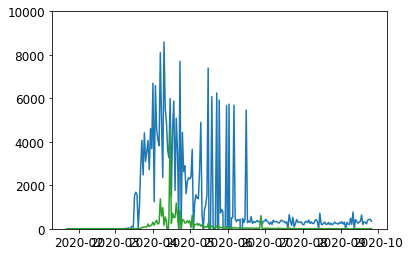

In [ ]:
import matplotlib.pyplot as plt
plt.plot(nyc.submission_date, nyc.new_case, color='tab:blue', label='New Cases')
plt.plot(nyc.submission_date, nyc.new_death, color='tab:green', label='New Deaths')
plt.ylim([0,10000])

(0.0, 10000.0)

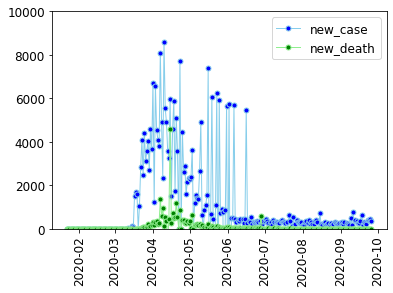

In [ ]:
plt.plot( 'submission_date', 'new_case', data=nyc, marker='o', markerfacecolor='blue', markersize=5, color='skyblue', linewidth=1)
plt.plot( 'submission_date', 'new_death', data=nyc, marker='o', markerfacecolor='green', markersize=5, color='lightgreen', linewidth=1)
plt.legend()
plt.xticks(rotation=90)
plt.ylim([0,10000])

In [ ]:
print('mean=%.3f stdv=%.3f' % (np.mean(nyc.new_case), np.std(nyc.new_case)))
print('mean=%.3f stdv=%.3f' % (np.mean(nyc.new_death), np.std(nyc.new_death)))

mean=977.795 stdv=2073.430
mean=95.586 stdv=342.075


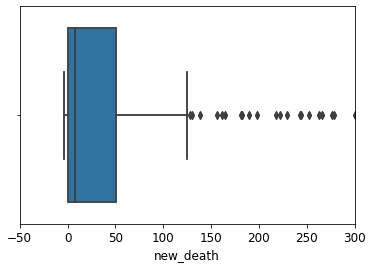

In [ ]:
ax = sns.boxplot(x = nyc.new_death)
ax = sns.boxplot(x = nyc.new_death).set(xlim=(-50, 300))

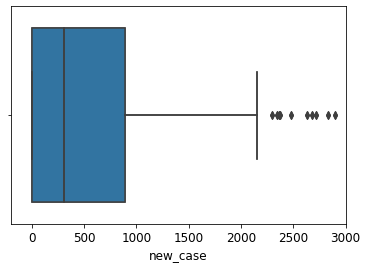

In [ ]:
ax = sns.boxplot(x = nyc.new_case)
ax = sns.boxplot(x = nyc.new_case).set(xlim=(-200, 3000))

In [ ]:
### Based on thse visualizations the data does NOT look like a normal distribution
### However, we need to perform a normality test to confirm
### The D’Agostino’s K^2 test calculates summary statistics from the data, 
### namely kurtosis and skewness, to determine if the data distribution departs 
### from the normal distributio

from scipy.stats import normaltest

stat, p = normaltest(nyc.new_case)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
	print('Sample looks Gaussian (fail to reject H0)')
else:
	print('Sample does not look Gaussian (reject H0)')


Statistics=54.072, p=0.000
Sample does not look Gaussian (reject H0)


In [ ]:
### Now we have proven that our data is NOT normally distributed.
### The next step is to perform a correlation between our variable, so
### we must use a test that is for NON-GAUSSIAN data
### Therefore, we must use a Spearman correlation test (not a Pearson!)

In [ ]:
from scipy.stats import spearmanr
corr, _ = spearmanr(nyc.new_case, nyc.new_death)
print('Spearmans correlation: %.3f' % corr)


Spearmans correlation: 0.860


In [ ]:
### Size of Correlation	Interpretation
### https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3576830/
### .90 to 1.00 -->	Very high positive (negative) correlation
### .70 to .90 -->	High positive (negative) correlation
### .50 to .70 -->	Moderate positive (negative) correlation
### .30 to .50 -->	Low positive (negative) correlation
### .00 to .30 -->	negligible correlation

### According to the calculated Spearman correlation coefficient of 0.860
### there is a high positive correlation between the quantity of new cases,
### and the new deaths in NYC related to COVID19.

### Thanks for reading :)
### -CV